# Homework 3 - Find the perfect place to stay in Texas!


### Group 30 - Almagout Nagham, Cervelli Riccardo, Macchi Gabriele

The aim of this homework consists in analyzing the text of Airbnb property listings and building a search engine. But what is AirBnb? It’s the world’s biggest accommodation-sharing site. How does Airbnb work? We reveal all you need to know. We have tried to do some analysis based on our programming knowledge. 
[Here's a direct link to that data set we used.](https://www.kaggle.com/PromptCloudHQ/airbnb-property-data-from-texas/downloads/Airbnb_Texas_Rentals.csv/1)

![airbnb](http://www.dailyonline.it/wp-content/uploads/2017/09/Airbnb-e1505572097823.png)

In [1]:
import nltk
import csv
import string
import pandas as pd
import numpy as np
import re, string, unicodedata
import contractions
import inflect
import heapq
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from collections import defaultdict
from langdetect import detect
from scipy import spatial
import folium
import branca.colormap as cm
import seaborn as sns
from geopy import distance
import os
from branca.element import Template, MacroElement
from datetime import datetime
import matplotlib.pyplot as plt

## Step 1: Data

We wanted to take a look at the user data we have for this homework so we made this little notebook to share our findings and discuss about those. At the moment we've started with the basic user data. Please, feel free to comment with anything you think it can be improved or fixed. We are not professional in this field and there will be mistakes or things that can be improved. This is the flow we took and there are some plots. Let's see the data!

Here we read the data from the Airbnb_Texas_Rentals.csv file.
Each row in the data set is a specific listing that's available for renting on Airbnb.
Here are some of the more important columns:
- city: the name of the city where the rental can accommodate hosts
- bedrooms_count: number of bedrooms included in the rental
- bathrooms: number of bathrooms included in the rental
- average_rate_per_night: nightly price for the rental



In [12]:
data=pd.read_csv('Airbnb_Texas_Rentals.csv',usecols=["average_rate_per_night",
                                                      "bedrooms_count",
                                                      "city",
                                                      "date_of_listing",
                                                      "description",
                                                      "latitude",
                                                      "longitude",
                                                      "title",
                                                      "url"])

### Removing the duplicates data:
We found a lot of duplicate documents, where they have same content and they differ just in 'url' column, so we removed the duplicates data, using pandas drop duplicates.

In [13]:
data=data.drop_duplicates(["average_rate_per_night",
                          "bedrooms_count",
                          "city",
                          "date_of_listing",
                          "description",
                          "latitude",
                          "longitude",
                          "title"],keep='first')

In [45]:
n_documents = len(data)
n_documents

11664

so we can see that there are more than 6000 duplicates!

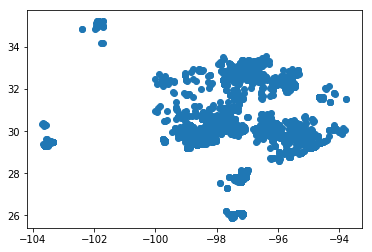

In [14]:
plt.scatter(data['longitude'], data['latitude'])

Chances are you've already done this before, and it's a perfectly adequate way to get started working with locations. In this plot we see...not much, really. If you're very intimately familiar with the layout of these cities, you will probably be able to make sense of some of these clusters which are, to me, not being from the city, totally mysterious.
In other words, this plot is missing something important: geospatial context.
Additionally, this display is unprojected, it's displayed in terms of raw coordinates. The amount of distance contained in a coordinate degree varies greatly depending on where you are, so this naive plot potentially pretty badly distorts distances.


## Step 2: Create documents

According to the goal of this homework, we deal with different files creating a .tsv file for each record of the dataset. We store the documents in a directory with inside one file per house review.

In [15]:
for index,r in data.iterrows():
    row=data.loc[index:index]
    row.to_csv('./tsv_files/doc_'+str(index+1)+'.tsv',sep='\t',header=None)

## Step 3: Search Engine

We want to create two different Search Engines that, given as input a query, return the houses that match the query.
As a first common step, you must preprocess the documents by:
1. Removing stopwords
2. Removing punctuation
3. Stemming
4. Anything else you think it's needed

In [16]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    
    new_words = []
    words=re.sub(r'\n',' ',words)
    for word in words.split():
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [17]:
def cleaning_data(a):
    '''
    this function takes a string in input, cleans it, and returns a list with all the 'clean' words in the initial string
    '''
    a=a.replace('\\n',' ')
    a=a.replace('\\',' ')
    a=remove_non_ascii(a)
    a=to_lowercase(a)
    a=remove_punctuation(a)
    a=replace_numbers(a)
    a=remove_stopwords(a)
    a=stem_words(a)
    a=lemmatize_verbs(a)
    return a
    

### Something about Search Engine

Search engines such as Google, Yahoo deploy their own fleet of “bots” across the internet to build map of the web and scrape information, or “index”, from the pages that they hit. When indexing pages and ranking them for specific search queries, search engines will take into account a variety of factors .

### Compiling and storing the vocabulary

Here we are creating the vocabulary dictionary, firstly we create a dictionary, then for each word in the doc's description and title, we check if the word is already in the dictionary, if not we add it to and we assign it an id, if it is in the dictionary we skip and continue.
#### Our vocabuary file will be a dictionary of this format:
##### {vocabulary_1:term_id_1vocabulary_2:term_id_2,....}

In [20]:
def compile_vocabulary(vocabulary_dict, column_number, data):
    term_id = 1
    for index,r in data.iterrows():
        row=data.loc[index:index]
        dato = pd.read_csv("./tsv_files/doc_"+str(index+1) +'.tsv', encoding = 'UTF-8', delimiter = "\t", header = None)
        a = dato.values[0][column_number]#i take the column 'descritpion'
        if isinstance(a, str):
            a = cleaning_data(a)
            for word in a:
                if word not in vocabulary_dict:
                    vocabulary_dict[word] = term_id
                    term_id += 1
                else:
                    term_id_word = vocabulary_dict[word]

Here we call the previous function to create the vocabulary file for each doc description and title and we store it in memory

In [21]:
#here we created the voculabory, we saved it and then loaded it.
vocabulary = {}
compile_vocabulary(vocabulary, 5, data) #description
compile_vocabulary(vocabulary, 8, data) #title
# Storing the vocabulary file 
np.save('vocabulary.npy', vocabulary) 
# Loading the vocabulary file
vocabulary = np.load('vocabulary.npy').item()

### Compiling and storing the inverted index

Here we are creating the inverted index file. Firstly we create a dictionary, then for each word in the doc's description and title, we check if the word is in the dictionary and if not we add its id to the dictionary and we add the doc name to the list (value) of the word. Instead if it is already in the dictionary we add the doc number to the list of the word.

The inverted index will be a dictionary of this format:
##### { term_id_1:[document_1, document_2, document_4], term_id_2:[document_1, document_3, document_5, document_6], ...}

In [24]:
def compile_inv_ind(vocabulary, inv_ind, column_number,data):
    for index,r in data.iterrows():
        row=data.loc[index:index]
        dato = pd.read_csv("./tsv_files/doc_"+str(index+1) +'.tsv', encoding = 'UTF-8', delimiter = "\t", header = None)
        a = dato.values[0][column_number]#i take the column 'descritpion'
        if isinstance(a, str): 
            a = cleaning_data(a)
            for word in a:
                if vocabulary[word] in inv_ind:
                    if index+1 in inv_ind[vocabulary[word]]:
                        pass
                    else:
                        inv_ind[vocabulary[word]].append(index+1)
                else:
                    inv_ind[vocabulary[word]] = [index+1]

Here we call the previous function to compile the inverted index firstly on docs' description and then on their title.

In [25]:
#and here we created the inverted index
inv_ind = {}
compile_inv_ind(vocabulary, inv_ind, 5,data) #description
compile_inv_ind(vocabulary, inv_ind, 8,data) #title
# Storing the inverted index
np.save('inv_ind.npy', inv_ind) 
# Loading the inverted index
inv_ind = np.load('inv_ind.npy').item()

## Execute the query

First we define a function that takes as input a query and returns a list with the corresponding term_id(s), then for each term id in the query we retrive the list of this term id, which contains all docs that contain this term id, from the vocabulary inverted index.
Then we get the intersection of these lists.

In [26]:
def get_query_term_id(query):
    '''
    this function takes as input a query and returns a list with the corresponding term_id(s)
    '''
    # query = query.split()
    for i in range(len(query)):
        if query[i] in vocabulary:
            query[i] = vocabulary[query[i]]
        else:
            query[i] = 0
    return query

#### Vocabulary file that we got 

In [ ]:
vocabulary #we choose to not print our vocabulary because tthe display of our markdown is slowed down a lot

#### Inverted Index file that we got

In [ ]:
inv_ind # as before, #we choose to not print our inverted index because tthe display of our markdown is slowed down a lot

## Execute the query
First we define a function that takes as input a query and returns a list with the corresponding term_id(s), then for each term id in the query we retrive the list of this term id, which conatin all docs that contain this term id, from the vocabulary inverted index.
Then we get the intersection of these lists.

In [30]:
def execute_query(query, inv_ind = inv_ind, vocabulary = vocabulary):
    '''
    this function executes the query
    '''
    all_docs = set(range(18260))
    query = cleaning_data(query)
    query = get_query_term_id(query)
    for i in query:
        if i == 0:
            return set()
        else:
            all_docs = all_docs.intersection(set(inv_ind[i]))
    return all_docs

In [31]:
query = input('what apartment are you looking for? ')
result = execute_query(query)

what apartment are you looking for? beautiful house with garden


In [32]:
result

{567,
 2057,
 2558,
 3233,
 3385,
 3759,
 3877,
 4112,
 4207,
 4583,
 5510,
 6226,
 6448,
 7491,
 7928,
 8131,
 8484,
 9138,
 10416,
 10589,
 11332,
 12928,
 13310,
 14255,
 15559,
 17598}

## Display the result
We use HTML library and html statments to display the result

In [34]:
from IPython.core.display import display, HTML
table = pd.DataFrame()
for doc in result:
    with open('./tsv_files/doc_'+ str(doc) +'.tsv') as ftmp:
        Cov = pd.read_csv('./tsv_files/doc_'+ str(doc) +'.tsv', sep='\t',
                          names = ["0","1","2","City","Date","Description", "Lang", "Lat", "Title","URL"])
        table=table.append(Cov[["Title","City","Description","URL"]])
html="""
<table style="width:100%;text-aligh:left">
<thead><tr><th style="text-aligh:left">Title</th><th>Description</th><th>City</th><th>URL</th></tr></thead>
<tbody>"""
for i in range(len(table)):
    table.iloc[i]['Description']=' '.join(table.iloc[i]['Description'].split(' ')[0:40])
    # we are displaying just the first 40 words because it's more nice to view
    html+="""
    <tr><td style="text-aligh:left">"""+table.iloc[i]['Title']+\
    """</td><td>"""+table.iloc[i]['Description']+\
    """</td><td  style="text-aligh:center">"""+\
    table.iloc[i]['City']+"""</td><td><a href='"""+\
    table.iloc[i]['URL']+"""'>"""+table.iloc[i]['URL']+"""</a></td></tr>"""
html+="""</tbody></table>"""

In [35]:
display(HTML(html))


Title,Description,City,URL
Dallas Downton Abbey,"Our Dallas Downton Abbey is close to downtown, Southern Methodist University, George W. Bush Library, the beautiful shops at Northpark and Highland Park Village, The Perot Museum, and Love field Airport. You’ll love this gorgeous retreat in the city because",Dallas,https://www.airbnb.com/rooms/14254297?location=Addison%2C%20TX
Beautiful queen bedroom in NW Austin,"My house is close to Lakeline Mall, highways and the toll road, restaurants, grocery stores, hike and bike trails, parks, Lake Travis. You’ll love my home because of the quiet, safe neighborhood, the light, the really comfy queen size bed,",Austin,https://www.airbnb.com/rooms/16755710?location=Cedar%20Park%2C%20TX
East Austin Hillside Gem,"Beautiful and modern 3Br, 2.5Ba located minutes from downtown. Amenities include front deck, back patio, peaceful backyard with tiered gardens and fire pits. There is also gym equipment, wifi, Xbox, and cable with HBO, Showtime, Starz, etc. There is free",Austin,https://www.airbnb.com/rooms/17555039?location=Bastrop%20County%2C%20TX
"The Woodlands, BEAUTIFUL HOME, 1 Floor, 2 BT, 3 BD","Attractions: The Woodlands, incredible views, golf courses, theme parks with tennis courts and lakes, pools, cycle paths, tranquility and quality of life for the family.\nYou will love my house because of its cozy spaces with high ceilings in an excellent",Spring,https://www.airbnb.com/rooms/13065223?location=Conroe%2C%20TX
The Vintage room in Fort Worth,"Our place is a beautiful cozy open concept house in a quiet neighborhood surrounded by nature with easy access to many shops/restaurants and close enough to the city. We are centrally located about 24 minutes from DFW airport, about 21",Fort Worth,https://www.airbnb.com/rooms/18959678?location=Colleyville%2C%20TX
Relaxing house and garden,"Three room house situated in the Hill Country of Texas near vineyards and rolling hills. Only 30 minutes to downtown Austin, 15 minutes to San Marcos, 20 minutes to beautiful Wimberley, and 15 minutes to the wineries of Texas.",Kyle,https://www.airbnb.com/rooms/2927741?location=Buda%2C%20TX
Slade Street Carriage Pool House,"This historic carriage house has been beautifully converted into a rustic cozy conveniently located space just two blocks from the town square. The cottage sits on a 100 acre property next to the century old farm house, large pool, gardens,",Coldspring,https://www.airbnb.com/rooms/15882909?location=Cleveland%2C%20TX
"Vintage Airstream in East Austin, T","This fantastic backyard garden oasis has been completely remodeled and is available for rent by the night. Hardwood floors, AC unit, heater, full size bed with organic cotton mattress and 600 thread count Egyptian Cotton sheets. Fully equipped bathroom with",Austin,https://www.airbnb.com/rooms/949922?location=Colorado%20River%2C%20TX
Carriage House on Ranch Homestead in Hill Country,"Renovated historic barn with concrete floors, original sliding doors, exposed limestone wall. Accommodates two with queen bed with mattress topper. Seating area has TV, wi-fi, books. Kitchen has butcher block, granite tops, microwave, blender, coffee/espresso maker. Spacious bath has walk-in",Helotes,https://www.airbnb.com/rooms/6504290?location=Boerne%2C%20TX
New!3BR Fort Worth House near AT&T Stadium w/ Spa!,"Explore the City of Cowboys and Culture from this 3-bedroom, 2.5-bathroom Fort Worth vacation rental house. With 1,600 square feet of well-appointed living space, this charming home offers sleeping accommodations for 8, a beautiful backyard garden, a spa and four",Fort Worth,https://www.airbnb.com/rooms/19193017?location=Colleyville%2C%20TX


## STEP 3.2   Conjunctive query & Ranking score

In [46]:
def compile_inv_ind_TFIDF(vocabulary, inv_ind, inv_ind_TFIDF, column_number_a, column_number_b,data):
    '''
    this function takes as input a vocabulary, the inverted index with only the documents and compile a new inverted index with
    not only the documents but a tuple for each document with his ID and his TFIDF
    '''
    # errors = 0
    for index,r in data.iterrows():
        dato = pd.read_csv("./tsv_files/doc_"+str(index+1) +'.tsv', encoding = 'UTF-8', delimiter = "\t", header = None)
        a = str(dato.values[0][column_number_a]) + ' ' + str(dato.values[0][column_number_b]) #i take the column 'descritpion'
        if isinstance(a, str): 
            a = cleaning_data(a)
            len_a = len(a)
            
            #TF
            dict_TF = defaultdict(int)            
            for word in a:
                try:
                    term_id = vocabulary[word]
                    dict_TF[term_id] += 1
                except:
                    pass
                    # errors += 1
            #TFIDF
            for term_id in dict_TF:
                inv_ind_TFIDF[term_id].append((index+1, (dict_TF[term_id]/len_a) * (np.log(n_documents/(len(inv_ind[term_id]))))))
                
    # print(errors)

here we execute the function compile_inv_ind_TFIDF and we save the inverted index TFIDF in a file

In [47]:
inv_ind_TFIDF = defaultdict(list)
compile_inv_ind_TFIDF(vocabulary, inv_ind, inv_ind_TFIDF, 5, 8,data) #description and title

In [48]:
# Storing the inverted index
np.save('inv_ind_TFIDF.npy', inv_ind_TFIDF) 

### Loading Inverted Index TFIDF

In [49]:
# Loading the inverted index
inv_ind_TFIDF = np.load('inv_ind_TFIDF.npy').item()

Defining the Cosine Similarity between two arrays:

In [50]:
def cosine_similarity(I,II):
    return(1 - spatial.distance.cosine(I, II))

## Execute the query

In [51]:
def vectorize_query(query):
    query = cleaning_data(query)
    
    #TF
    dict_TF = defaultdict(float)
    len_q = len(query)
    for word in query:
        term_id = vocabulary[word]
        dict_TF[term_id] += 1/len_q
    return (dict_TF)

In [52]:
def execute_query_rank(query, inv_ind_TFIDF = inv_ind_TFIDF):
    '''
    this function executes the query 
    '''
    result = execute_query(query)
    query = vectorize_query(query)
    # print(query)
    # print(query.values())
    dict_list_doc_words = defaultdict(list) # a dictionary where the keys are the documents with non 0 similarity and the 
                                            # values are the TFIDF of the query's words in the order of the query
    for word in query:
        for elem in inv_ind_TFIDF[word]:
            if elem[0] in result:
                dict_list_doc_words[elem[0]].append(elem[1])
    # print(dict_list_doc_words)
    
    
    # cosine similarities
    heap = []
    list_query = list(query.values())
    
    for doc in dict_list_doc_words:
        heapq.heappush(heap, (cosine_similarity(list_query, dict_list_doc_words[doc]), doc))
        
    return heap

In [53]:
query = input('what are you looking for? ')
k = int(input('how many results do you want? '))
heap_result = heapq.nlargest(k, execute_query_rank(query))

what are you looking for? beautiful house with garden
how many results do you want? 20


In [54]:
heap_result

[(0.9966653964039002, 4112),
 (0.9653854455364522, 8484),
 (0.9653854455364522, 6448),
 (0.9653854455364521, 8131),
 (0.946649878449588, 2057),
 (0.9460822907490092, 3877),
 (0.9266889855073981, 14255),
 (0.9266792310415906, 3233),
 (0.9266792310415904, 17598),
 (0.9266792310415904, 13310),
 (0.9266792310415904, 12928),
 (0.9266792310415904, 11332),
 (0.9266792310415904, 7928),
 (0.9266792310415904, 6226),
 (0.9266792310415904, 4207),
 (0.9266792310415904, 3759),
 (0.9266792310415904, 3385),
 (0.9266792310415904, 2558),
 (0.9266792310415903, 15559),
 (0.9266792310415903, 10589)]

The cosine of two non-zero vectors can be derived by using the Euclidean dot product formula:
Given two vectors of attributes, A and B, the cosine similarity, cos(θ), is represented using a dot product and magnitude as

$${\displaystyle \mathbf {A} \cdot \mathbf {B} =\left\|\mathbf {A} \right\|\left\|\mathbf {B} \right\|\cos \theta }$$


$${\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$$


In [55]:
def return_cos_sim(doc_id, heap):
    '''
    this function takes in input a doc_id and the heap and returns the cos_sim of the heap
    '''
    for tup in heap:
        if tup[1] == doc_id:
            return tup[0]

In [57]:
from IPython.core.display import display, HTML
table = pd.DataFrame()
for doc in heap_result:
    doc = doc[1]
    with open('./tsv_files/doc_'+ str(doc) +'.tsv') as ftmp:
        Cov = pd.read_csv('./tsv_files/doc_'+ str(doc) +'.tsv', sep='\t',
                          names = ["ID","1","2","City","Date","Description", "Lang", "Lat", "Title","URL"])
        table=table.append(Cov[["ID","Title","City","Description","URL"]])
html="""
<table style="width:100%">
<thead><tr><th style="text-aligh:left">Title</th><th>Description</th><th>City</th><th>URL</th><th>Cosine Similarity</th></tr></thead>
<tbody>"""
for i in range(len(table)):
    score=return_cos_sim(table.iloc[i]['ID']+1, heap_result)
    table.iloc[i]['Description']=' '.join(table.iloc[i]['Description'].split(' ')[0:40])
    html+="""
    <tr><td style="text-aligh:left">"""+table.iloc[i]['Title']+\
    """</td><td>"""+table.iloc[i]['Description']+\
    """</td><td  style="text-aligh:left">"""+\
    table.iloc[i]['City']+"""</td><td><a href='"""+\
    table.iloc[i]['URL']+"""'>"""+table.iloc[i]['URL']+\
    """</a></td><td>"""+str(score)+"""</td></tr>"""
html+="""</tbody></table>"""

C:\Users\gabbr\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [58]:
display(HTML(html))

Title,Description,City,URL,Cosine Similarity
"The Woodlands, BEAUTIFUL HOME, 1 Floor, 2 BT, 3 BD","Attractions: The Woodlands, incredible views, golf courses, theme parks with tennis courts and lakes, pools, cycle paths, tranquility and quality of life for the family.\nYou will love my house because of its cozy spaces with high ceilings in an excellent location, beautiful views, and proximity to the great shopping areas.\nIt is a single story house with a large garden; ideal for couples, business travelers, and families with children.",Spring,https://www.airbnb.com/rooms/13065223?location=Conroe%2C%20TX,0.9966653964039002
Relaxing house and garden,"Three room house situated in the Hill Country of Texas near vineyards and rolling hills. Only 30 minutes to downtown Austin, 15 minutes to San Marcos, 20 minutes to beautiful Wimberley, and 15 minutes to the wineries of Texas.",Kyle,https://www.airbnb.com/rooms/2927741?location=Buda%2C%20TX,0.9653854455364522
New!3BR Fort Worth House near AT&T Stadium w/ Spa!,"Explore the City of Cowboys and Culture from this 3-bedroom, 2.5-bathroom Fort Worth vacation rental house. With 1,600 square feet of well-appointed living space, this charming home offers sleeping accommodations for 8, a beautiful backyard garden, a spa and four season sun/moon dining room. Whether you spend your stay in the sunny backyard oasis or venture out downtown, this Texas property guarantees you and your group the vacation of a lifetime!",Fort Worth,https://www.airbnb.com/rooms/19193017?location=Colleyville%2C%20TX,0.9653854455364522
Serene Farmhouse on Natural Reserve,"Welcome to Karakia - a beautiful farm house on 100 acres of wildlife sanctuary land. Surrounded by gardens and orchards, the spacious house is a unique luxury treasure - with 14ft front doors, stain glass windows, and a wide wrap-around porch.",Wimberley,https://www.airbnb.com/rooms/9509505?location=Canyon%20Lake%2C%20TX,0.9653854455364521
East Austin Hillside Gem,"Beautiful and modern 3Br, 2.5Ba located minutes from downtown. Amenities include front deck, back patio, peaceful backyard with tiered gardens and fire pits. There is also gym equipment, wifi, Xbox, and cable with HBO, Showtime, Starz, etc. There is free offstreet parking for two cars. \n\nPerfect location for families(with kids or furry friends,) couples, business travelers or friends looking for a spacious and comfortable location with plenty of amenities. This house has beautiful sunset views of downtown Austin just 6 miles from Darrell K Royal Stadium, 8 miles from Zilker Park and 14 miles from Circuit of the Americas.",Austin,https://www.airbnb.com/rooms/17555039?location=Bastrop%20County%2C%20TX,0.946649878449588
Slade Street Carriage Pool House,"This historic carriage house has been beautifully converted into a rustic cozy conveniently located space just two blocks from the town square. The cottage sits on a 100 acre property next to the century old farm house, large pool, gardens, pasture, barn, and wooded nature trails with clear running streams...all just steps away. Downstairs trundle bed sleeps two with fully equipped kitchenette, private water closet, and outdoor private shower at back door. Large front porch with dining table and rocking chair faces pool and pasture. High ceiling design accommodates extra loft space and sleeping for two. A true treasure!",Coldspring,https://www.airbnb.com/rooms/15882909?location=Cleveland%2C%20TX,0.9460822907490092
Garden Bedroom,"Comfortable and private, the garden bedroom is ideal for a long weekend or festival stay. It features a private closet, a full-sized bed and a lovely view of the backyard. \n\nCommon spaces are here for your use as well. Cook a meal and stick to your travel budget, sit in the living room front window with a cup of coffee and watch the peacocks in the morning or enjoy the sunshine and garden from the back patio. \n\nIf being out and about in Austin is your goal, our neighborhood is central and there are many easy opti

## STEP 4: Define a new score!
Here we define a function to score the documents, our function is based on getting the difference between the user preference parameters and the doc parameters, produce each parameter difference with the priority of this parameter that user defined, then get the sum of all previous values.
To explain the function practically:
Firstly we will allow the user to enter his preference parameters, like: City, Maximum Price, Location and Bedrooms Count. And then we allow him to define the priority of the parameters.

If the user choose a preference city then the location will be the average of latitude and longitude in this city, if he choose a specific location then we will consider this location. 
### The function score:
Parameters that user define:
<ul>
<li>p=maximum price</li>
<li>l=location</li>
<li>bc=bedrooms count</li>
</ul>
<br>The priority that user define:
<ul>
<li>bc'=Bedrooms Priority</li>
<li>l'=Distance Priority</li>
<li>p'=Price Priority</li>
<li>d'=Date Priority</li>
</ul>



$$Docscore = pp’ * (p – docprice) +l’ * (l-doclocation) + d’ * (currentdate – docdate) + bc’ * (bc – docbedrooms)$$

In the case that user didn't define a priority, then the formula will be:

$$Docscore = (p – docprice) + (l-doclocation) + (bc – docbedrooms)$$

We consider the date just in case that the user give it an priority



After scoring all docs we will get the smallest n scores becuase the score here is the difference between the query and the docs.

In [86]:
import heapq
def get_document_score(query,data):
    s=0.0
    heap=[]
    for index,row in data.iterrows():
        if 'bedrooms' in q and row['bedrooms_count']!='NaN' and 'Bedrooms Priority' in q:
            s+=float(q['Bedrooms Priority'])*float((abs(float(row['bedrooms_count'])-q['bedrooms'])))
        else:
            s+=float((abs(float(row['bedrooms_count'])-q['bedrooms'])))
        if 'lat' in q and 'lon' in q and row['distance']!='NaN' and 'Distance Priority' in q:
            s+=float(q['Distance Priority'])*float((abs(row['distance'])))
        else:
            s+=float((abs(row['distance'])))
        if 'city' in q and row['distance']!='NaN' and 'Distance Priority' in q:
            s+=float(q['Distance Priority'])*float((abs(row['distance'])))
        else:
            s+=float((abs(row['distance'])))
        if 'price' in q and row['average_rate_per_night']!='NaN' and 'Price Priority' in q:
            s+=float(q['Price Priority'])*float((abs(row['average_rate_per_night']-q['price'])))
        else:
            s+=float((abs(row['average_rate_per_night']-q['price'])))
        if 'Date Priority' in q and row['date_diff']!='NaN' and int(q['Date Priority'])>1:
            s+=float(q['Date Priority'])*float((abs(row['date_diff'])))
        t=(s,index)
        heapq.heappush(heap,t)
        s=0.0
    return heap

### The query

In [87]:
dato=pd.read_csv('Airbnb_Texas_Rentals.csv',usecols=['city','average_rate_per_night','latitude','longitude'])
#I read the csv file but I consider only the useful column
dato=dato.fillna(0) #fillna change the values  from NaN to 0
dato=dato[dato.average_rate_per_night !=0]#in this passage we eliminate the value = 0  
dato["average_rate_per_night"] = dato["average_rate_per_night"].map(lambda x: str(x).lstrip("$")) #here we remove the $ symbol
dato['average_rate_per_night']=dato['average_rate_per_night'].apply(int) #here we convert the column to int
dato2=dato.groupby('city').mean() #we get the mean between the coordinates
dato2.head()

,average_rate_per_night,latitude,longitude
city,,,
Abilene,208.858491,32.432366,-99.737100
Addison,79.818182,32.951606,-96.840176
Alamo Heights,149.000000,29.474794,-98.463366
Alba,949.500000,32.857019,-95.630686
Aledo,227.400000,32.703646,-97.613628


![world](https://media1.tenor.com/images/f41eedf4cc4be29995b4f77dcf3534ed/tenor.gif)

In [65]:
## here I get the query from the user
q=dict()
p=input("Do you prefer a specific city?Please type Y for Yes and N for No: ")
if p=='Y':
    p=input("Which city? ")
    q['city']=p
p=input("Do you want to specify the maximum price?Please type Y for Yes and N for No: ")
if p=='Y':
    p=input("What is the maximum price? ")
    q['price']=p
p=input("Do you prefer to be near a specific point?Please type Y for Yes and N for No: ")
if p=='Y':
    p=input("Specifiy your latitude and longtitude?a an example 52.2296756, 21.0122287: ")
    q['lat']=p.split(',')[0]
    q['lon']=p.split(',')[1]
p=input("Do you want to specify the number of bedrooms?Please type Y for Yes and N for No: ")
if p=='Y':
    p=input("How many? ")
    q['bedrooms']=p
p=input("Do you want to assign priority to the parameters?Please type Y for Yes and N for No: ")
if p=='Y':
    print("Give number to each parameter to assigh it a priority: ")
    p=input("Date: ")
    q['Date Priority']=p
    p=input("Price: ")
    q['Price Priority']=p
    p=input("Distance: ")
    q['Distance Priority']=p
    p=input("Bedrooms: ")
    q['Bedrooms Priority']=p
    p=input("How many results you want?: ")
    result_number=p

Do you prefer a specific city?Please type Y for Yes and N for No: Y
Which city? Dallas
Do you want to specify the maximum price?Please type Y for Yes and N for No: Y
What is the maximum price? 400
Do you prefer to be near a specific point?Please type Y for Yes and N for No: N
Do you want to specify the number of bedrooms?Please type Y for Yes and N for No: Y
How many? 4
Do you want to assign priority to the parameters?Please type Y for Yes and N for No: Y
Give number to each parameter to assigh it a priority: 
Date: 3
Price: 6
Distance: 5
Bedrooms: 4
How many results you want?: 20


In [88]:
def get_location(query,data):
    '''
    This function gets the latitude and longitude of the location that user have chosen
    '''
    if 'lat' in query:
        lon=query['lon']
        lat=query['lat']
    elif 'city' in query:
        dd=data.loc[data['city'] == q['city']] 
        lon=np.mean(dd['longitude'])
        lat=np.mean(dd['latitude'])
    return lon,lat

We hypothesized that this landing page would increase relevance with its clearer content, and decrease page load time with its lighter code structure, among many other improvements. This would consequently lead to to a higher ranking for our page on search engine results.One of the key components of how Airbnb works is the [search engine](https://www.vayoo.com/blog/how-airbnb-search-engine-works) that enables the users to discover a listing matching the tastes and preferences. The platform processes close to two million active listings checking them against a complex set of conditions including calendar availability and geographic positioning. It also calculates ranking scores which are composed of hundreds of signals for each listing. Airbnb built a highly customized search system to be able to do all these.

In [89]:
d = data

In [90]:
#here we remove the $ symbol in the average rate per night column
d["average_rate_per_night"] = d["average_rate_per_night"].map(lambda x: str(x).lstrip("$"))

In [91]:
#here we replace the Studio value of the column bedrooms count by 1 because in general studios have just one room
x = d.loc[d.bedrooms_count == 'Studio', 'bedrooms_count'] = '1'

Here we drop the NaN values from the data because if we fill it with 0 then will affect on the result because we depend by our scoring process on the difference. 

In [92]:
d=d.dropna()

In [93]:
#Here to be sure that about the type of bedrooms count and average rate per night columns
d['bedrooms_count']=d['bedrooms_count'].apply(int)
d['average_rate_per_night']=d['average_rate_per_night'].apply(float)
q['price']=float(q['price'])
q['bedrooms']=int(q['bedrooms'])

C:\Users\gabbr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\gabbr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
#Here we calculate the distance between the location that user prefer and all docs location and add 
#a distance column to the result
import geopy.distance
dd=[]
lon,lat=get_location(q,d)
coords_1 = (lat,lon)
for index,row in d.iterrows():
    if row['latitude']!=0.0 and row['longitude']!=0.0:
        if not np.isnan(row['latitude']) and not np.isnan(row['longitude']):
            coords_2=(row['latitude'],row['longitude'])
            dd.append(geopy.distance.vincenty(coords_1, coords_2).km)
dist=pd.Series(dd)
d['distance']=dist.values

C:\Users\gabbr\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [95]:
#Here we define a function to get the difference in months between two 
#dates to use it in calculating the difference between query date and docs date
from datetime import datetime
currentMonth = datetime.now().month
currentYear = datetime.now().year
def months_between(date1,date2):
    if date1>date2:
        date1,date2=date2,date1
    m1=date1.year*12+date1.month
    m2=date2.year*12+date2.month
    months=m2-m1
    if date1.day>date2.day:
        months-=1
    elif date1.day==date2.day:
        seconds1=date1.hour*3600+date1.minute+date1.second
        seconds2=date2.hour*3600+date2.minute+date2.second
        if seconds1>seconds2:
            months-=1
    return months

In [96]:
#Here we calculate and add the date difference column to the data
from time import strptime
date_diff=[]
for index,row in d.iterrows():
    month_num=strptime(row['date_of_listing'].split(' ')[0][0:3],'%b').tm_mon
    date_diff.append(months_between(datetime(currentYear,currentMonth,1),datetime(int(row['date_of_listing'].split(' ')[1]),month_num,1)))
diff=pd.Series(date_diff)
d['date_diff']=diff.values

C:\Users\gabbr\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [97]:
heap=get_document_score(q,d)

In [98]:
heap

[(119.21953815472789, 15529),
 (131.8805109251128, 15291),
 (274.5493888037448, 1762),
 (275.2087984653633, 4993),
 (155.96431042380823, 17978),
 (325.9290682298902, 584),
 (537.0642604839084, 10553),
 (337.92931801541306, 2324),
 (316.28635458784174, 5614),
 (269.22076019988674, 3448),
 (203.01192290496238, 17045),
 (486.0953596985279, 3319),
 (371.51749959451865, 3813),
 (599.3076503216298, 2112),
 (598.7612263275936, 9008),
 (407.5893031083907, 4742),
 (367.5481638931672, 571),
 (447.8189536753913, 13409),
 (322.2319737359849, 2352),
 (295.8828648389375, 15276),
 (275.0799134783041, 5417),
 (465.9416985707122, 17487),
 (811.0814432211633, 3154),
 (580.2967738004129, 7695),
 (610.4772564464124, 1867),
 (632.6846885015937, 224),
 (535.1828468953227, 3604),
 (661.5138645259943, 3955),
 (708.5849338691918, 4124),
 (769.8861472186849, 981),
 (617.9338183742168, 2147),
 (725.9928288911615, 4582),
 (512.5826548796558, 1078),
 (378.4412759331432, 2380),
 (448.39407599891916, 5193),
 (469.43

Here we get the smaallest docs' score because as we mentioned before  our scoring process depends on the difference between the user preference and the docs' parameters, so that the smallest scores give us the smallest difference.

In [100]:
r=int(result_number)
result = heapq.nsmallest(r, heap)
lresult=[result[i][1] for i in range(len(result))]
from IPython.core.display import display, HTML
table = pd.DataFrame()
for doc in lresult:
    with open('./tsv_files/doc_'+ str(doc+1) +'.tsv') as ftmp:
        Cov = pd.read_csv('./tsv_files/doc_'+ str(doc+1) +'.tsv', sep='\t', 
                          names = ["0","1","2","City","Date","Description", "Lang", "Lat", "Title","URL"])
        table=table.append(Cov[["Title","City","Description","URL"]])

In [101]:
html=''
html="""
<table style="width:100%">
<thead><tr><th style="text-aligh:left">Ranking</th><th style="text-align: left">Title</th><th style="text-aligh:left">Description</th><th>City</th><th>URL</th></tr></thead>
<tbody>"""
for i in range(len(table)):
    table.iloc[i]['Description']=' '.join(table.iloc[i]['Description'].split(' ')[0:40])
    html+="""
    <tr><td style="text-aligh:left">"""+str(i)+"""</td><td style="text-aligh:left">"""+table.iloc[i]['Title']+"""</td><td>"""+table.iloc[i]['Description']+"""</td><td  style="text-aligh:center">"""+table.iloc[i]['City']+"""</td><td><a href='"""+table.iloc[i]['URL']+"""'>"""+table.iloc[i]['URL']+"""</a></td></tr>"""
html+="""</tbody></table>"""

In [102]:
display(HTML(html))

Ranking,Title,Description,City,URL
0,Perfect Dallas location!,"This location is perfect for all areas of Dallas. 15 min from downtown and 20 min to Mckinney / Frisco. The Galleria is 3 min away. \n\nNew, clean sheets for ALL beds. Tent with 2 sleeping bags if kids wants",Dallas,https://www.airbnb.com/rooms/15619350?location=Addison%2C%20TX
1,"Peaceful ""Ranch style"" Retreat","My place is close to family-friendly activities, the airport, public transport, nightlife, downtown, uptown and all highways. You’ll love my place because of the comfy beds, the coziness, the kitchen, the high ceilings and the open floor plan! My place",Dallas,https://www.airbnb.com/rooms/15781807?location=Addison%2C%20TX
2,Luxe Lakewood Smart Home Next to Everything!,"Our modern luxury home is located close to everything! Perfect for group getaways, large families and romantic weekends away to relax! Walk to Tietze Park during the day with the kids to splash around or to Greenville Ave at night",Dallas,https://www.airbnb.com/rooms/19086339?location=Balch%20Springs%2C%20TX
3,Private Home with Pool,Private home with pool. 3 bed 2 bath home just minutes from the city center.,Dallas,https://www.airbnb.com/rooms/16685774?location=Addison%2C%20TX
4,"DFW airport 4BR/3,5BA House + Pool","Only 10 minutes North of DFW airport, spacious 3400 sqf family house with pool and hot tub in quiet suburban neighborhood. Downtown Dallas, Six Flags, Cowboys Stadium, Rangers Stadium, Grapevine, and other popular tourist attractions are all within 1/2 hour",Irving,https://www.airbnb.com/rooms/9567794?location=Coppell%2C%20TX
5,Victorian Retreat,"10 minutes from from Dallas/Fort Worth International Airport, Verizon Theater at Grand Prairie, Lone Star Park at Grand Prairie, Airhogs Stadium, Six Flags Over Texas and Six Flags Hurricane Harbor. 15 minutes from AT&T Stadium and Globe Life Park. Equidistant",Grand Prairie,https://www.airbnb.com/rooms/14594683?location=Bedford%2C%20TX
6,Miguel's Retreat,"Beautiful quiet neighborhood, just 15 minutes from Downtown Dallas . Very close to restaurants, dining and shopping malls. Also 15 minutes from Joe Pool lakes",Duncanville,https://www.airbnb.com/rooms/16429254?location=Cedar%20Hill%2C%20TX
7,Brand New Home In Gated Community Near The Lake,"You’ll love our newly built home in a gated community, tucked away and walking distance from Lake Lewisville. It is conveniently located just miles away from Toyota Stadium, The Star, The Shops at Legacy (shopping & dining), and just a",Frisco,https://www.airbnb.com/rooms/17765765?location=Corinth%2C%20TX
8,1918 East Dallas Home,Completely renovated Prairie Style home less than 4 miles from Historic Downtown Dallas. This is a one of a kind 1-1/2 story home built in 1918. It has a fenced in back yard with a pool and backhouse.,Dallas,https://www.airbnb.com/rooms/8563573?location=Balch%20Springs%2C%20TX
9,3BR House 3.6 miles to AT&T stadium,"Sports fans will be pleased to discover the convenient location near popular venues, such as Globe Life Park - home of the Texas Rangers, and AT&T Stadium, the world-class event center for the Dallas Cowboys. For a different type of",Arlington,https://www.airbnb.com/rooms/15746070?location=Arlington%2C%20TX


![world](http://www.missionline.it/wp-content/uploads/2015/12/airbnb-gif-final-1024x576.gif)

# Our MAPS  

In [103]:
def marker(): #i create a function, that consider the house's prices and divided the marker by color
    price= int(data_2['average_rate_per_night'][house][1:])
    if price >250:  #if price >500 the markes becomes pink
        col='pink'
    if price <250: 
        col='purple'
    if price <150: 
        col='blue'
    if price <75: 
        col='red'
    return col    #and return the color based on the respective  price

In [104]:
data=pd.read_csv('Airbnb_Texas_Rentals.csv',usecols=['latitude','longitude','average_rate_per_night'])
'''data=data.drop_duplicates(["average_rate_per_night","latitude","longitude",],keep='first')'''
#i read the csv file but i consider only the useful column
data=data.fillna(0) #fillna change the values  from NaN to 0
data=data[data.average_rate_per_night !=0]#in this passage we eliminate the value = 0 
data.head()                                      #because in our opinion are useless to our analysis


,average_rate_per_night,latitude,longitude
0,$27,30.020138,-95.293996
1,$149,29.503068,-98.447688
2,$59,29.829352,-95.081549
3,$60,30.637304,-96.337846
4,$75,32.747097,-97.286434


In [105]:
x= float(input()) 
y= float(input())
Coordinate_inserite=[x,y]

32.892048
-96.871741


In [106]:
max_distance=int(input())#max distance between coordinates and the houses'position

2


In [110]:
positions=[] #we create an empty list
for index,row in d.iterrows(): #from 1 to the last row to our DF
    try:
        coordinates=[data['latitude'][index],data['longitude'][index]]
        distance_bet_houses=distance.distance(Coordinate_inserite, coordinates).km
        if distance_bet_houses <  max_distance: #if the conditions will be respect append positions
            positions.append(index)
    except: pass

In [111]:
positions  # the houses in our "max_distance"

[3446,
 9605,
 13253,
 13724,
 13729,
 15091,
 16062,
 16553,
 16992,
 17045,
 17085,
 17237,
 17699,
 17965,
 18249]

In [112]:
data_2 = data.loc[positions] # add the value associated to positions in our DF
data_2

,average_rate_per_night,latitude,longitude
3446,$33,32.893318,-96.861888
9605,$37,32.894930,-96.862067
13253,$1000,32.882023,-96.875111
13724,$369,32.907781,-96.862183
13729,$49,32.894479,-96.853260
15091,$40,32.896913,-96.869532
16062,$67,32.901806,-96.868001
16553,$95,32.903109,-96.866734
16992,$75,32.885247,-96.870147
17045,$394,32.883228,-96.861051


In [113]:
Map_to_print1=folium.Map(
    location=Coordinate_inserite, #you can put any coordinates.
    zoom_start=14,                         
    tiles='openstreetmap ' #i choose  openstreetmap  because i like this kind of map, but there were many kind of representation.   
)

In [114]:
max_distance_metri=max_distance*1000
legend= cm.StepColormap(['red','blue','purple','pink'], index=[0, 350, 700,800 ], vmin=0, vmax=1000)

In [117]:
folium.Marker(
    location=Coordinate_inserite,
    popup='Location',
    icon=folium.Icon(color='black', icon='home') #here we create the folium icon and we put the house inside because the homework speaks about houses
).add_to(Map_to_print1)
folium.Circle(    #here we create the folium circle
    location=Coordinate_inserite,
    radius=max_distance_metri,#the size of the circle
    color='#696969',
    fill_color='#ff0000',
    fill_opacity= 0.05,
).add_to(Map_to_print1)
for house in data_2.T: 
    others_coordinates=[data_2['latitude'][house],data_2['longitude'][house]] 
    folium.Marker(
    location=others_coordinates,
    icon=folium.Icon(color=marker(), icon='home'),
    popup=data_2['average_rate_per_night'][house]    
).add_to(Map_to_print1)

legend.caption = ' divided by Price'
legend.add_to(Map_to_print1)
Map_to_print1.add_child(legend)
# In this case, I would like to show you my map here, but on GitHub this map won't be represents,so i save the map in my folder,
Map_to_print1.save(os.path.join('', r"houses.html"))
Map_to_print1